# 5.SQL and Dataframes

References:

* Spark-SQL, <https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes>


# 5.1  Example Walkthrough
Follow the Spark SQL and Dataframes Examples below!

### Initialize PySpark

First, we use the findspark package to initialize PySpark.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# Initialize PySpark
os.environ["JAVA_HOME"]="/lrz/sys/compilers/java/jdk1.8.0_112"
APP_NAME = "PySpark Dataframes and Performance"
SPARK_MASTER="local[16]"


import pyspark
import pyspark.sql
from pyspark.sql import Row
conf=pyspark.SparkConf().setAppName(APP_NAME)
conf=pyspark.SparkConf().setAppName(APP_NAME).set("spark.local.dir", os.path.join(os.getcwd(), "tmp"))
sc = pyspark.SparkContext(master=SPARK_MASTER, conf=conf)
spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()
print("PySpark initiated...")

PySpark initiated...


In [2]:
sc

<SparkContext master=local[16] appName=PySpark Dataframes and Performance>

### Hello, World!

Loading data, mapping it and collecting the records into RAM...

In [3]:
# Load the text file using the SparkContext
csv_lines = sc.textFile("../data/example.csv")

# Map the data to split the lines into a list
data = csv_lines.map(lambda line: line.split(","))

# Collect the dataset into local RAM
data.collect()

[['Russell Jurney', 'Relato', 'CEO'],
 ['Florian Liebert', 'Mesosphere', 'CEO'],
 ['Don Brown', 'Rocana', 'CIO'],
 ['Steve Jobs', 'Apple', 'CEO'],
 ['Donald Trump', 'The Trump Organization', 'CEO'],
 ['Russell Jurney', 'Data Syndrome', 'Principal Consultant']]

### Creating Rows

Creating `pyspark.sql.Rows` out of your data so you can create DataFrames...

In [4]:
# Convert the CSV into a pyspark.sql.Row
def csv_to_row(line):
    parts = line.split(",")
    row = Row(
      name=parts[0],
      company=parts[1],
      title=parts[2]
    )
    return row

# Apply the function to get rows in an RDD
rows = csv_lines.map(csv_to_row)

### Creating DataFrames from RDDs

Using the `RDD.toDF()` method to create a dataframe, registering the `DataFrame` as a temporary table with Spark SQL, and counting the jobs per person using Spark SQL.

In [5]:
# Convert to a pyspark.sql.DataFrame
rows_df = rows.toDF()

# Register the DataFrame for Spark SQL
rows_df.registerTempTable("executives")

# Generate a new DataFrame with SQL using the SparkSession
job_counts = spark.sql("""
SELECT
  name,
  COUNT(*) AS total
  FROM executives
  GROUP BY name
""")
job_counts.show()

# Go back to an RDD
job_counts.rdd.collect()

+---------------+-----+
|           name|total|
+---------------+-----+
|   Donald Trump|    1|
|Florian Liebert|    1|
|      Don Brown|    1|
| Russell Jurney|    2|
|     Steve Jobs|    1|
+---------------+-----+



[Row(name='Donald Trump', total=1),
 Row(name='Florian Liebert', total=1),
 Row(name='Don Brown', total=1),
 Row(name='Russell Jurney', total=2),
 Row(name='Steve Jobs', total=1)]

# 5.2-5.4 NASA DataSet

5.2 Create a Spark-SQL table with fields for IP/Host and Response Code from the NASA Log file! 

In [3]:
from pyspark.sql import Row
nasa_lines = sc.textFile("../data/nasa/NASA_access_log_Jul95")
spark_dataframe=nasa_lines.map(lambda a: Row(host=a.split()[0], response_code=a.split()[-2] if len(a.split())>2 else "No Value")).toDF()
spark_dataframe.registerTempTable("nasa")
spark_dataframe.show()

+--------------------+-------------+
|                host|response_code|
+--------------------+-------------+
|        199.72.81.55|          200|
|unicomp6.unicomp.net|          200|
|      199.120.110.21|          200|
|  burger.letters.com|          304|
|      199.120.110.21|          200|
|  burger.letters.com|          304|
|  burger.letters.com|          200|
|     205.212.115.106|          200|
|         d104.aa.net|          200|
|      129.94.144.152|          200|
|unicomp6.unicomp.net|          200|
|unicomp6.unicomp.net|          200|
|unicomp6.unicomp.net|          200|
|         d104.aa.net|          200|
|         d104.aa.net|          200|
|         d104.aa.net|          200|
|      129.94.144.152|          304|
|      199.120.110.21|          200|
|ppptky391.asahi-n...|          200|
|  net-1-141.eden.com|          200|
+--------------------+-------------+
only showing top 20 rows



5.3 Run an SQL query that outputs the number of occurrences of each HTTP response code!

In [7]:
%%time
results = spark.sql("""select response_code, count(*) as count from nasa group by response_code""").toPandas()

CPU times: user 20.3 ms, sys: 2.24 ms, total: 22.5 ms
Wall time: 5.33 s


5.4 Cachen Sie den Dataframe und führen Sie dieselbe Query nochmals aus! Messen Sie die Laufzeit für das Cachen und für die Ausführungszeit der Query!

In [8]:
%%time
spark_dataframe.cache()
spark_dataframe.count()

CPU times: user 3.23 ms, sys: 445 µs, total: 3.67 ms
Wall time: 5.33 s


In [9]:
%%time
results = spark.sql("""select response_code, count(*) as count from nasa group by response_code""").toPandas()

CPU times: user 9.45 ms, sys: 11.4 ms, total: 20.9 ms
Wall time: 595 ms


5.5 Führen Sie diesselbe Query mit/ohne Cache und 8, 16 Cores aus! Dokumentieren und erklären Sie das Ergebnis!

In [10]:
results = spark.sql("""select response_code, count(*) as count from nasa group by response_code""").toPandas()

### 5.6 Weak Scaling: 
* Create two RDD with 2x and 4x of the size of the NASA log dataset! Persist the dataset in the Spark Cache!
* Measure and plot the response times for all 3 datasets (1x, 2x, 4x)!

In [4]:
sdf2x = spark_dataframe
for i in range(1): sdf2x = sdf2x.union(sdf2x)
sdf2x.cache()

sdf4x = spark_dataframe
for i in range(2): sdf4x = sdf4x.union(sdf4x)
sdf4x.cache()

sdf8x = spark_dataframe
for i in range(3): sdf8x = sdf8x.union(sdf8x)
sdf8x.cache()

sdf16x = spark_dataframe
for i in range(4): sdf16x = sdf16x.union(sdf16x)
sdf16x.cache()

DataFrame[host: string, response_code: string]

In [5]:
%%time
spark_dataframe.count()

CPU times: user 2.42 ms, sys: 357 µs, total: 2.77 ms
Wall time: 5.34 s


1891715

In [6]:
%%time
sdf2x.count()

CPU times: user 3.6 ms, sys: 0 ns, total: 3.6 ms
Wall time: 5.94 s


3783430

In [7]:
%%time
sdf4x.count()

CPU times: user 5.4 ms, sys: 214 µs, total: 5.61 ms
Wall time: 11.4 s


7566860

In [8]:
%%time
sdf8x.count()

CPU times: user 5.88 ms, sys: 4.22 ms, total: 10.1 ms
Wall time: 20.3 s


15133720

In [9]:
%%time
sdf16x.count()

CPU times: user 12.2 ms, sys: 4.78 ms, total: 16.9 ms
Wall time: 40.2 s


30267440

In [10]:
sdf16x.registerTempTable("nasa16")

In [12]:
spark.sql("select response_code, count(*) from nasa16 group by response_code").show()

+-------------+--------+
|response_code|count(1)|
+-------------+--------+
|          200|27224544|
|          302|  745168|
|          501|     224|
|          404|  173520|
|          403|     864|
|          500|     992|
|          304| 2122032|
|     No Value|      16|
|          400|      80|
+-------------+--------+



### Plot Data Load Times

<BarContainer object of 5 artists>

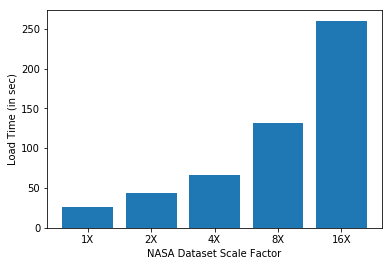

In [18]:
load_times = [26.5, 43.6, 66, 131, 260]
ind = np.arange(len(load_times))
fig, ax = plt.subplots()
ax.set_xticks(ind)
ax.set_xticklabels(('1X', '2X', '4X', '8X', '16X'))
ax.set_ylabel('Load Time (in sec)')
ax.set_xlabel('NASA Dataset Scale Factor')
plt.bar(ind, load_times)

### Query Response Times

In [17]:
%%time
spark_dataframe.groupBy('response_code').count().collect()

CPU times: user 15.9 ms, sys: 807 µs, total: 16.7 ms
Wall time: 373 ms


[Row(response_code='200', count=1701534),
 Row(response_code='302', count=46573),
 Row(response_code='501', count=14),
 Row(response_code='404', count=10845),
 Row(response_code='403', count=54),
 Row(response_code='500', count=62),
 Row(response_code='304', count=132627),
 Row(response_code='No Value', count=1),
 Row(response_code='400', count=5)]

In [18]:
%%time
sdf2x.groupBy('response_code').count().collect()

CPU times: user 6.96 ms, sys: 10.8 ms, total: 17.7 ms
Wall time: 507 ms


[Row(response_code='200', count=3403068),
 Row(response_code='302', count=93146),
 Row(response_code='501', count=28),
 Row(response_code='404', count=21690),
 Row(response_code='403', count=108),
 Row(response_code='500', count=124),
 Row(response_code='304', count=265254),
 Row(response_code='No Value', count=2),
 Row(response_code='400', count=10)]

In [19]:
%%time
sdf4x.groupBy('response_code').count().collect()

CPU times: user 11.7 ms, sys: 7.76 ms, total: 19.5 ms
Wall time: 756 ms


[Row(response_code='200', count=6806136),
 Row(response_code='302', count=186292),
 Row(response_code='501', count=56),
 Row(response_code='404', count=43380),
 Row(response_code='403', count=216),
 Row(response_code='500', count=248),
 Row(response_code='304', count=530508),
 Row(response_code='No Value', count=4),
 Row(response_code='400', count=20)]

In [20]:
%%time
sdf8x.groupBy('response_code').count().collect()

CPU times: user 21.1 ms, sys: 1.04 ms, total: 22.1 ms
Wall time: 1.2 s


[Row(response_code='200', count=13612272),
 Row(response_code='302', count=372584),
 Row(response_code='501', count=112),
 Row(response_code='404', count=86760),
 Row(response_code='403', count=432),
 Row(response_code='500', count=496),
 Row(response_code='304', count=1061016),
 Row(response_code='No Value', count=8),
 Row(response_code='400', count=40)]

In [21]:
%%time
sdf16x.groupBy('response_code').count().collect()

CPU times: user 19.2 ms, sys: 9.35 ms, total: 28.5 ms
Wall time: 2.27 s


[Row(response_code='200', count=27224544),
 Row(response_code='302', count=745168),
 Row(response_code='501', count=224),
 Row(response_code='404', count=173520),
 Row(response_code='403', count=864),
 Row(response_code='500', count=992),
 Row(response_code='304', count=2122032),
 Row(response_code='No Value', count=16),
 Row(response_code='400', count=80)]

### Plot GroupBy Query Times

In [25]:
group_by_times = [2.46, 2.72,  3.57, 5.99, 7.36]

<BarContainer object of 5 artists>

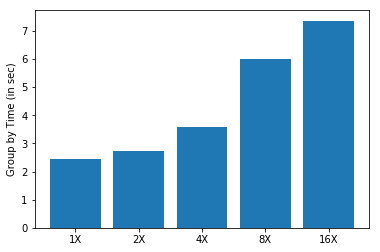

In [26]:
ind = np.arange(len(group_by_times))
fig, ax = plt.subplots()
ax.set_xticks(ind)
ax.set_xticklabels(('1X', '2X', '4X', '8X', '16X'))
ax.set_ylabel('Group by Time (in sec)')
plt.bar(ind, group_by_times)

### 5.7 Strong Scaling

  * Measure the runtime for the query for 8, 16, 32, 64, 128, 256 cores for 1x and 16x datasets!
  * Compute the speedup and efficiency!
  * Plot and explain the responses!

In [23]:
import os
# Initialize PySpark
APP_NAME = "PySpark Dataframes and Performance"
SPARK_MASTER="local[2]"

import pyspark
import pyspark.sql
from pyspark.sql import Row
import time

sc.stop()

def init_spark(number_cores):
    # If there is no SparkSession, create the environment
    APP_NAME = "PySpark Dataframes and Performance (%d)"%number_cores
    # Initialize PySpark
    os.environ["JAVA_HOME"]="/lrz/sys/compilers/java/jdk1.8.0_112"
    APP_NAME = "PySpark Dataframes and Performance"
    SPARK_MASTER="local[%d]"%number_cores
    conf=pyspark.SparkConf().setAppName(APP_NAME)
    conf=pyspark.SparkConf().setAppName(APP_NAME).set("spark.local.dir", os.path.join(os.getcwd(), "tmp"))
    sc = pyspark.SparkContext(master=SPARK_MASTER, conf=conf)
    spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()
    print("PySpark initiated. Cores: %d"%number_cores)
    return sc



for c in [1,2,4,8,16,32,64,128,256,512]:
    sc = init_spark(c)
    nasa_lines = sc.textFile("../data/nasa/NASA_access_log_Jul95")
    spark_dataframe=nasa_lines.map(lambda a: Row(host=a.split()[0], response_code=a.split()[-2] if len(a.split())>2 else "No Value")).toDF()
    sdf16x = spark_dataframe
    for i in range(4): sdf16x = sdf16x.union(sdf16x)
    sdf16x.cache().count()
    spark_dataframe.cache().count()
    
    for i in range(5):
        start = time.time()
        sdf16x.groupBy('response_code').count().collect()
        end = time.time()    
        print("16, %d, %.3f"%(c, end-start))
        time.sleep(2)
        start = time.time()
        spark_dataframe.groupBy('response_code').count().collect()
        end = time.time()
        print("1,  %d, %.3f"%(c, end-start))
        time.sleep(2)
    sc.stop()
    

PySpark initiated. Cores: 1
16, 1, 13.589
1,  1, 1.475
16, 1, 14.099
1,  1, 1.473
16, 1, 14.219
1,  1, 1.414
16, 1, 13.590
1,  1, 1.568
16, 1, 14.075
1,  1, 1.400
PySpark initiated. Cores: 2
16, 2, 6.849
1,  2, 0.783
16, 2, 6.864
1,  2, 0.821
16, 2, 6.760
1,  2, 0.819
16, 2, 6.985
1,  2, 0.777
16, 2, 6.889
1,  2, 0.784
PySpark initiated. Cores: 4
16, 4, 6.499
1,  4, 0.536
16, 4, 4.716
1,  4, 0.518
16, 4, 5.780
1,  4, 0.539
16, 4, 6.133
1,  4, 0.535
16, 4, 6.592
1,  4, 0.560
PySpark initiated. Cores: 8
16, 8, 2.205
1,  8, 0.345
16, 8, 2.113
1,  8, 0.345
16, 8, 2.173
1,  8, 0.405
16, 8, 2.152
1,  8, 0.345
16, 8, 2.130
1,  8, 0.368
PySpark initiated. Cores: 16
16, 16, 1.361
1,  16, 0.287
16, 16, 1.340
1,  16, 0.300
16, 16, 1.349
1,  16, 0.275
16, 16, 1.344
1,  16, 0.294
16, 16, 1.568
1,  16, 0.327
PySpark initiated. Cores: 32
16, 32, 1.536
1,  32, 0.281
16, 32, 1.154
1,  32, 0.264
16, 32, 1.162
1,  32, 0.296
16, 32, 1.235
1,  32, 0.276
16, 32, 1.146
1,  32, 0.300
PySpark initiated. Cores:

### Plot Result

In [27]:
import pandas as pd
df = pd.read_csv("performance.csv")

In [28]:
df_agg = df.groupby(['Scale', ' Cores'], as_index=False).agg({' Time': ['std', 'mean']})
df_agg.columns = ['-'.join(col) for col in  df_agg.columns]

In [29]:
df_agg

,Scale-,Cores-,Time-std,Time-mean
0,1,1,0.817576,6.1581
1,1,2,0.462444,3.5395
2,1,4,0.227183,2.0647
3,1,8,0.405666,1.7826
4,8,1,3.957158,25.0748
5,8,2,0.722123,12.9202
6,8,4,1.010993,7.3240
7,8,8,1.867504,5.9398
8,16,1,3.684847,48.8592
9,16,2,2.118824,22.1822


In [33]:
df_agg.plot(kind='line', x=' Cores-', y=' Time-mean', c=['r', 'g', 'b'],  legend=True)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2ae86ed61598> (for post_execute):


ValueError: Invalid RGBA argument: ['r', 'g', 'b']

ValueError: Invalid RGBA argument: ['r', 'g', 'b']

<Figure size 432x288 with 1 Axes>

In [35]:
df['Cores']

KeyError: 'Cores'

### 5.6 Convert the output to a Pandas dataframe and calculate the percentage of total for each response code!

In [17]:
results["counts_pct"]=(results["count"]/results["count"].sum()*100) 
results

,response_code,count,counts_pct
0,200,1701534,89.946636
1,302,46573,2.461946
2,501,14,0.000740
3,404,10845,0.573289
4,403,54,0.002855
5,500,62,0.003277
6,304,132627,7.010940
7,No Value,1,0.000053
8,400,5,0.000264


## Alternative Implementation

In [28]:
lines = spark.read.format("text").load(os.path.join(os.getcwd(), "../data/nasa/spark-streaming/NASA_access_log_Jul95"))

see <https://stackoverflow.com/questions/40467936/how-do-i-get-the-last-item-from-a-list-using-pyspark>

In [50]:
lines = lines.withColumn('split_value', F.split((lines.value), " "))
lines = lines.withColumn('response_code', lines.split_value[F.size(lines.split_value)-2])
rc_counts = lines.groupBy("response_code").count()

In [51]:
lines.take(5)

[Row(value='199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245', response_code='200', split_value=['199.72.81.55', '-', '-', '[01/Jul/1995:00:00:01', '-0400]', '"GET', '/history/apollo/', 'HTTP/1.0"', '200', '6245']),
 Row(value='unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985', response_code='200', split_value=['unicomp6.unicomp.net', '-', '-', '[01/Jul/1995:00:00:06', '-0400]', '"GET', '/shuttle/countdown/', 'HTTP/1.0"', '200', '3985']),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085', response_code='200', split_value=['199.120.110.21', '-', '-', '[01/Jul/1995:00:00:09', '-0400]', '"GET', '/shuttle/missions/sts-73/mission-sts-73.html', 'HTTP/1.0"', '200', '4085']),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0', response_code='304', split_value=['bu

In [52]:
rc_counts.collect()

[Row(response_code='200', count=1701534),
 Row(response_code=None, count=1),
 Row(response_code='302', count=46573),
 Row(response_code='501', count=14),
 Row(response_code='404', count=10845),
 Row(response_code='403', count=54),
 Row(response_code='500', count=62),
 Row(response_code='304', count=132627),
 Row(response_code='400', count=5)]